In [14]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_PCA3.pth'


In [15]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [16]:
# Extract hidden states/reference embeddings
from sklearn.decomposition import PCA

def extract_hidden_states(texts, model, tokenizer, apply_pca=True, n_components=3, batch_size=128):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    
    # 应用 PCA 降维
    if apply_pca:
        pca = PCA(n_components=n_components)
        hidden_states = pca.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using PCA.")
        
    return hidden_states

def extract_reference_embeddings(references, model, tokenizer, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [17]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [18]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 12/12 [17:46<00:00, 88.90s/it]


Hidden states reduced to 3 dimensions using PCA.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 12/12 [00:28<00:00,  2.40s/it]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 12/12 [17:45<00:00, 88.82s/it]


Hidden states reduced to 3 dimensions using PCA.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


In [21]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=771 and hidden_dim=256


Training Epochs:   2%|▏         | 10/500 [00:00<00:05, 93.84it/s]

Epoch 10/500, Loss: 0.5767
Test Accuracy at Epoch 10: 44.41%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.44      0.49      0.46       283
non_infringement       0.45      0.40      0.42       298

        accuracy                           0.44       581
       macro avg       0.44      0.45      0.44       581
    weighted avg       0.44      0.44      0.44       581

New best model saved with accuracy 44.41% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.44      0.49      0.46       283
non_infringement       0.45      0.40      0.42       298

        accuracy                           0.44       581
       macro avg       0.44      0.45      0.44       581
    weighted avg       0.44      0.44      0.44       581

Epoch 20/500, Loss: 0.5111
Test Accuracy at Epoch 20: 53.53%


Training Epochs:   4%|▍         | 21/500 [00:00<00:04, 99.15it/s]

Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.53      0.47      0.50       283
non_infringement       0.54      0.60      0.57       298

        accuracy                           0.54       581
       macro avg       0.53      0.53      0.53       581
    weighted avg       0.53      0.54      0.53       581

New best model saved with accuracy 53.53% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.53      0.47      0.50       283
non_infringement       0.54      0.60      0.57       298

        accuracy                           0.54       581
       macro avg       0.53      0.53      0.53       581
    weighted avg       0.53      0.54      0.53       581

Epoch 30/500, Loss: 0.5241
Test Accuracy at Epoch 30: 58.00%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringeme

Training Epochs:   7%|▋         | 33/500 [00:00<00:05, 86.92it/s]

New best model saved with accuracy 58.00% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.60      0.41      0.49       283
non_infringement       0.57      0.74      0.64       298

        accuracy                           0.58       581
       macro avg       0.59      0.58      0.57       581
    weighted avg       0.58      0.58      0.57       581



Training Epochs:   8%|▊         | 42/500 [00:00<00:05, 86.10it/s]

Epoch 40/500, Loss: 0.4406
Test Accuracy at Epoch 40: 57.66%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.58      0.49      0.53       283
non_infringement       0.58      0.66      0.62       298

        accuracy                           0.58       581
       macro avg       0.58      0.57      0.57       581
    weighted avg       0.58      0.58      0.57       581



Training Epochs:  11%|█         | 54/500 [00:00<00:04, 96.03it/s]

Epoch 50/500, Loss: 0.4023
Test Accuracy at Epoch 50: 56.63%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.56      0.54      0.55       283
non_infringement       0.57      0.59      0.58       298

        accuracy                           0.57       581
       macro avg       0.57      0.57      0.57       581
    weighted avg       0.57      0.57      0.57       581

Epoch 60/500, Loss: 0.3631
Test Accuracy at Epoch 60: 59.38%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.62      0.44      0.51       283
non_infringement       0.58      0.74      0.65       298

        accuracy                           0.59       581
       macro avg       0.60      0.59      0.58       581
    weighted avg       0.60      0.59      0.58       581

New best model saved with accuracy 59.38% at epoch 60
Best Classification Report at Epoch 60:
            

Training Epochs:  17%|█▋        | 86/500 [00:00<00:04, 85.79it/s]

Epoch 70/500, Loss: 0.3253
Test Accuracy at Epoch 70: 60.93%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.63      0.47      0.54       283
non_infringement       0.60      0.74      0.66       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.60       581
    weighted avg       0.61      0.61      0.60       581

New best model saved with accuracy 60.93% at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.63      0.47      0.54       283
non_infringement       0.60      0.74      0.66       298

        accuracy                           0.61       581
       macro avg       0.61      0.61      0.60       581
    weighted avg       0.61      0.61      0.60       581

Epoch 80/500, Loss: 0.3264
Test Accuracy at Epoch 80: 61.10%
Classification Report at Epoch 80:
            

Training Epochs:  19%|█▉        | 96/500 [00:01<00:04, 88.16it/s]

Epoch 90/500, Loss: 0.2827
Test Accuracy at Epoch 90: 66.78%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.65       283
non_infringement       0.67      0.70      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

New best model saved with accuracy 66.78% at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.67      0.64      0.65       283
non_infringement       0.67      0.70      0.68       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 100/500, Loss: 0.2531
Test Accuracy at Epoch 100: 66.61%
Classification Report at Epoch 100:
         

Training Epochs:  25%|██▌       | 125/500 [00:01<00:04, 84.68it/s]

Epoch 110/500, Loss: 0.3108
Test Accuracy at Epoch 110: 63.17%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.60      0.72      0.66       283
non_infringement       0.68      0.54      0.60       298

        accuracy                           0.63       581
       macro avg       0.64      0.63      0.63       581
    weighted avg       0.64      0.63      0.63       581

Epoch 120/500, Loss: 0.2173
Test Accuracy at Epoch 120: 68.16%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.67      0.67      0.67       283
non_infringement       0.69      0.69      0.69       298

        accuracy                           0.68       581
       macro avg       0.68      0.68      0.68       581
    weighted avg       0.68      0.68      0.68       581

New best model saved with accuracy 68.16% at epoch 120
Best Classification Report at Epoch 120:
    

Training Epochs:  27%|██▋       | 134/500 [00:01<00:04, 75.70it/s]

Epoch 130/500, Loss: 0.2074
Test Accuracy at Epoch 130: 67.13%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.69      0.59      0.63       283
non_infringement       0.66      0.75      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581

Epoch 140/500, Loss: 0.1843
Test Accuracy at Epoch 140: 70.22%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.74      0.61      0.67       283
non_infringement       0.68      0.79      0.73       298

        accuracy                           0.70       581
       macro avg       0.71      0.70      0.70       581
    weighted avg       0.71      0.70      0.70       581

New best model saved with accuracy 70.22% at epoch 140
Best Classification Report at Epoch 140:
    

Training Epochs:  34%|███▎      | 168/500 [00:01<00:03, 95.67it/s]

Epoch 150/500, Loss: 0.1620
Test Accuracy at Epoch 150: 72.46%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.79      0.59      0.68       283
non_infringement       0.69      0.85      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.72      0.72       581

New best model saved with accuracy 72.46% at epoch 150
Best Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.79      0.59      0.68       283
non_infringement       0.69      0.85      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.72      0.72       581

Epoch 160/500, Loss: 0.1436
Test Accuracy at Epoch 160: 72.29%
Classification Report at Epoch 160:
    

Training Epochs:  38%|███▊      | 189/500 [00:02<00:03, 92.27it/s]

Epoch 170/500, Loss: 0.2356
Test Accuracy at Epoch 170: 64.03%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.76      0.38      0.51       283
non_infringement       0.60      0.89      0.72       298

        accuracy                           0.64       581
       macro avg       0.68      0.63      0.61       581
    weighted avg       0.68      0.64      0.62       581

Epoch 180/500, Loss: 0.1745
Test Accuracy at Epoch 180: 72.81%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.80      0.58      0.68       283
non_infringement       0.69      0.87      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

New best model saved with accuracy 72.81% at epoch 180
Best Classification Report at Epoch 180:
    

Training Epochs:  42%|████▏     | 210/500 [00:02<00:03, 84.67it/s]

Epoch 200/500, Loss: 0.1306
Test Accuracy at Epoch 200: 72.29%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.78      0.60      0.68       283
non_infringement       0.69      0.84      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.73      0.72      0.72       581

Epoch 210/500, Loss: 0.1187
Test Accuracy at Epoch 210: 72.81%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       283
non_infringement       0.69      0.85      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581



Training Epochs:  47%|████▋     | 233/500 [00:02<00:02, 95.57it/s]

Epoch 220/500, Loss: 0.1091
Test Accuracy at Epoch 220: 73.84%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.80      0.61      0.69       283
non_infringement       0.70      0.86      0.77       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.73       581
    weighted avg       0.75      0.74      0.73       581

New best model saved with accuracy 73.84% at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.80      0.61      0.69       283
non_infringement       0.70      0.86      0.77       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.73       581
    weighted avg       0.75      0.74      0.73       581

Epoch 230/500, Loss: 0.1016
Test Accuracy at Epoch 230: 73.67%
Classification Report at Epoch 230:
    

Training Epochs:  53%|█████▎    | 267/500 [00:02<00:02, 96.57it/s]

Epoch 250/500, Loss: 0.0886
Test Accuracy at Epoch 250: 73.32%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       283
non_infringement       0.70      0.85      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 260/500, Loss: 0.0827
Test Accuracy at Epoch 260: 73.32%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       283
non_infringement       0.70      0.85      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 270/500, Loss: 0.0770
Test Accuracy at Epoch 270: 73.32%
Classification Report at Epoch 270:
 

Training Epochs:  57%|█████▋    | 287/500 [00:03<00:02, 86.01it/s]

Epoch 280/500, Loss: 0.0715
Test Accuracy at Epoch 280: 73.32%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       283
non_infringement       0.70      0.85      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.73      0.73       581
    weighted avg       0.74      0.73      0.73       581

Epoch 290/500, Loss: 0.0661
Test Accuracy at Epoch 290: 72.63%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       283
non_infringement       0.69      0.85      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581



Training Epochs:  61%|██████    | 306/500 [00:03<00:02, 88.67it/s]

Epoch 300/500, Loss: 0.0609
Test Accuracy at Epoch 300: 72.98%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.69       283
non_infringement       0.69      0.85      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.72       581
    weighted avg       0.74      0.73      0.73       581

Epoch 310/500, Loss: 0.0558
Test Accuracy at Epoch 310: 72.98%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.69       283
non_infringement       0.69      0.85      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.73      0.72       581
    weighted avg       0.74      0.73      0.73       581



Training Epochs:  68%|██████▊   | 339/500 [00:03<00:01, 92.13it/s]

Epoch 320/500, Loss: 0.2255
Test Accuracy at Epoch 320: 70.22%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.69      0.70      0.69       283
non_infringement       0.71      0.71      0.71       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

Epoch 330/500, Loss: 0.0831
Test Accuracy at Epoch 330: 71.08%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.67       283
non_infringement       0.68      0.83      0.75       298

        accuracy                           0.71       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.71      0.71       581

Epoch 340/500, Loss: 0.0659
Test Accuracy at Epoch 340: 72.46%
Classification Report at Epoch 340:
 

Training Epochs:  72%|███████▏  | 360/500 [00:04<00:01, 92.27it/s]

Epoch 350/500, Loss: 0.0544
Test Accuracy at Epoch 350: 72.46%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.80      0.58      0.67       283
non_infringement       0.68      0.86      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.72      0.72       581

Epoch 360/500, Loss: 0.0494
Test Accuracy at Epoch 360: 71.94%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.79      0.58      0.67       283
non_infringement       0.68      0.86      0.76       298

        accuracy                           0.72       581
       macro avg       0.74      0.72      0.71       581
    weighted avg       0.73      0.72      0.71       581



Training Epochs:  76%|███████▋  | 382/500 [00:04<00:01, 100.38it/s]

Epoch 370/500, Loss: 0.0440
Test Accuracy at Epoch 370: 72.63%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 380/500, Loss: 0.0406
Test Accuracy at Epoch 380: 72.63%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 390/500, Loss: 0.0378
Test Accuracy at Epoch 390: 72.63%
Classification Report at Epoch 390:
 

Training Epochs:  83%|████████▎ | 417/500 [00:04<00:00, 102.22it/s]

Epoch 400/500, Loss: 0.0353
Test Accuracy at Epoch 400: 72.63%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 410/500, Loss: 0.0331
Test Accuracy at Epoch 410: 72.63%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 420/500, Loss: 0.0310
Test Accuracy at Epoch 420: 72.63%
Classification Report at Epoch 420:
 

Training Epochs:  88%|████████▊ | 440/500 [00:04<00:00, 90.26it/s] 

Epoch 430/500, Loss: 0.0291
Test Accuracy at Epoch 430: 72.63%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 440/500, Loss: 0.0273
Test Accuracy at Epoch 440: 72.63%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581



Training Epochs:  93%|█████████▎| 464/500 [00:05<00:00, 101.77it/s]

Epoch 450/500, Loss: 0.0256
Test Accuracy at Epoch 450: 72.63%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 460/500, Loss: 0.0241
Test Accuracy at Epoch 460: 72.63%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581



Training Epochs:  97%|█████████▋| 487/500 [00:05<00:00, 99.27it/s] 

Epoch 470/500, Loss: 0.0226
Test Accuracy at Epoch 470: 72.63%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 480/500, Loss: 0.0212
Test Accuracy at Epoch 480: 72.63%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581

Epoch 490/500, Loss: 0.0199
Test Accuracy at Epoch 490: 72.81%
Classification Report at Epoch 490:
 

Training Epochs: 100%|██████████| 500/500 [00:05<00:00, 91.76it/s] 
/tmp/ipykernel_326179/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.0187
Test Accuracy at Epoch 500: 72.81%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       283
non_infringement       0.69      0.86      0.76       298

        accuracy                           0.73       581
       macro avg       0.74      0.72      0.72       581
    weighted avg       0.74      0.73      0.72       581



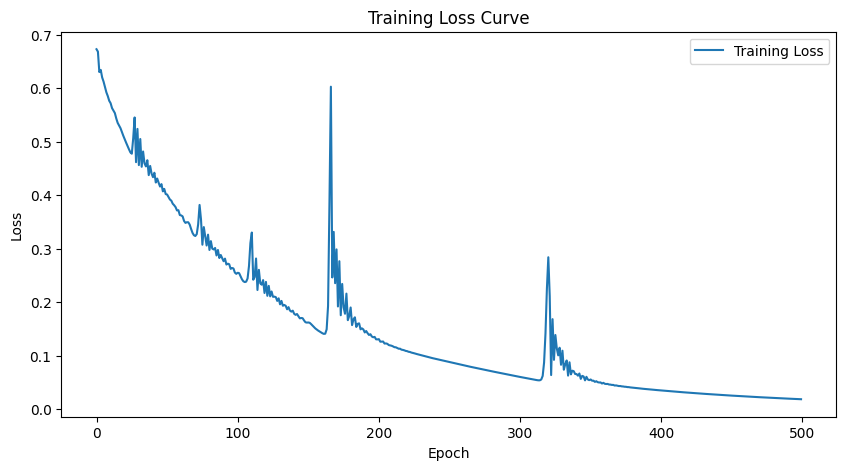

Final Model Accuracy: 73.84%


In [22]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [23]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_PCA3.pth'.


In [24]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.80      0.61      0.69       283
non_infringement       0.70      0.86      0.77       298

        accuracy                           0.74       581
       macro avg       0.75      0.74      0.73       581
    weighted avg       0.75      0.74      0.73       581



/tmp/ipykernel_326179/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


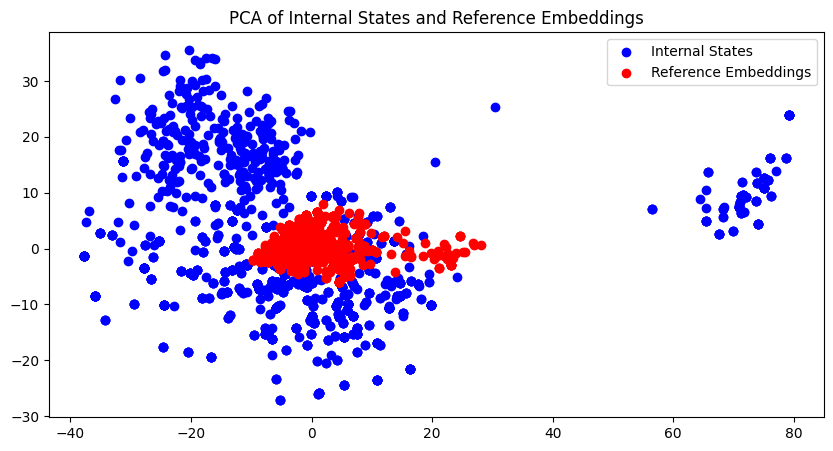

In [25]:
import numpy as np
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA 降维
pca = PCA(n_components=2)
hidden_states_pca = pca.fit_transform(X_non_infringement)
reference_embeddings_pca = pca.fit_transform(reference_embeddings_non_infringement)

# 绘制 internal states 和 reference embeddings，使用不同颜色区分
plt.figure(figsize=(10, 5))

# 绘制 internal states (蓝色)
plt.scatter(hidden_states_pca[:, 0], hidden_states_pca[:, 1], c='blue', label='Internal States')

# 绘制 reference embeddings (红色)
plt.scatter(reference_embeddings_pca[:, 0], reference_embeddings_pca[:, 1], c='red', label='Reference Embeddings')

plt.title("PCA of Internal States and Reference Embeddings")
plt.legend()

plt.show()

# # 计算欧氏距离和余弦相似度
# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# euclidean_dist = euclidean_distances(reference_embeddings_non_infringement, X_non_infringement_combined)
# cosine_sim = cosine_similarity(reference_embeddings_non_infringement, X_non_infringement_combined)

# print("Euclidean Distance Matrix Shape: ", euclidean_dist.shape)
# print("Cosine Similarity Matrix Shape: ", cosine_sim.shape)
